In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

import renom as rm
from renom.optimizer import Sgd

In [2]:
# Datapath must point to the directory containing the mldata folder.
data_path = "../dataset"
mnist = fetch_mldata('MNIST original', data_home=data_path)

X = mnist.data
y = mnist.target

# Rescale the image data to 0 ~ 1.
# 画像を 0-1 の間にスケーリングする
X = X.astype(np.float32)
X /= X.max()        # X = X / 255

# ラベルを one-hot 表現に変換する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
labels_train = LabelBinarizer().fit_transform(y_train).astype(np.float32)
labels_test = LabelBinarizer().fit_transform(y_test).astype(np.float32)

# Training data size.
N = len(X_train)

In [17]:
class Mnist(rm.Model):

    def __init__(self):
        super(Mnist, self).__init__()
        self._layer1 = rm.Dense(100)
        self._layer2 = rm.Dense(10)

    def forward(self, x):
        out = self._layer2(rm.relu(self._layer1(x)))
        return out

    # 今回のカギとなる重みの正則化、weight_decay
    def weight_decay(self):
#         print("self._layer1.params.w: ", self._layer1.params.w.shape)
#         print("type(self._layer1.params.w): ", type(self._layer1.params.w.shape))
        weight_decay = rm.sum(self._layer1.params.w**2) + rm.sum(self._layer2.params.w**2)
#         print("weight_decay: ", weight_decay.shape)
#         print("type(weight_decay): ", type(weight_decay.shape)) 
#         print(weight_decay)
        return weight_decay

In [18]:
# Choose neural network.
network = Mnist()

In [19]:
# Hyper parameters
batch = 64
epoch = 10

optimizer = Sgd(lr = 0.1)

learning_curve = []
test_learning_curve = []

for i in range(epoch):
    perm = np.random.permutation(N)
    loss = 0
    for j in range(0, N // batch):
        train_batch = X_train[perm[j * batch:(j + 1) * batch]]
        responce_batch = labels_train[perm[j * batch:(j + 1) * batch]]

        # The computational graph is only generated for this block:
        with network.train():
            l = rm.softmax_cross_entropy(network(train_batch), responce_batch)
            if hasattr(network, "weight_decay"):
                l += 0.0001 * network.weight_decay()

        # Back propagation
        grad = l.grad()

        # Update
        grad.update(optimizer)

        # Changing type to ndarray is recommended.
        loss += l.as_ndarray()

    train_loss = loss / (N // batch)

    # Validation
    test_loss = rm.softmax_cross_entropy(network(X_test), labels_test).as_ndarray()
    test_learning_curve.append(test_loss)
    learning_curve.append(train_loss)
    print("epoch %03d train_loss:%f test_loss:%f"%(i, train_loss, test_loss))

epoch 000 train_loss:0.338232 test_loss:0.191759
epoch 001 train_loss:0.186984 test_loss:0.138166
epoch 002 train_loss:0.146580 test_loss:0.114256
epoch 003 train_loss:0.126843 test_loss:0.107564
epoch 004 train_loss:0.113151 test_loss:0.093856
epoch 005 train_loss:0.104685 test_loss:0.088540
epoch 006 train_loss:0.097786 test_loss:0.080399
epoch 007 train_loss:0.092149 test_loss:0.083691
epoch 008 train_loss:0.088325 test_loss:0.074468
epoch 009 train_loss:0.084657 test_loss:0.071902


[[663   0   2   0   0   0   1   0   0   0]
 [  0 762   6   0   0   0   1   3   0   0]
 [  4   1 690   0   1   0   1   3   3   0]
 [  0   1   7 698   0   5   0   0   7   2]
 [  0   1   1   1 658   0   2   2   0   9]
 [  0   2   1   2   1 629   3   0   2   3]
 [  0   0   3   0   0   5 700   0   1   0]
 [  2   1   9   2   2   0   0 695   0   3]
 [  2   4   4   2   1   4   0   0 673   0]
 [  2   0   1   6   5   3   0   5   2 685]]
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       666
        1.0       0.99      0.99      0.99       772
        2.0       0.95      0.98      0.97       703
        3.0       0.98      0.97      0.98       720
        4.0       0.99      0.98      0.98       674
        5.0       0.97      0.98      0.98       643
        6.0       0.99      0.99      0.99       709
        7.0       0.98      0.97      0.98       714
        8.0       0.98      0.98      0.98       690
        9.0       0.98      0.97      

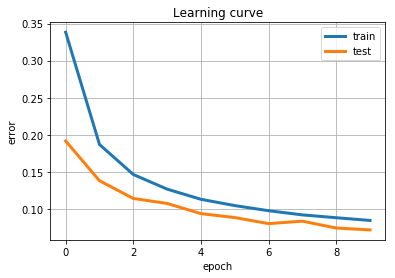

In [20]:
predictions = np.argmax(network(X_test).as_ndarray(), axis=1)

# Confusion matrix and classification report.
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Learning curve.
plt.plot(learning_curve, linewidth=3, label="train")
plt.plot(test_learning_curve, linewidth=3, label="test")
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend()
plt.grid()
plt.show()